# Import libraries

In [431]:
import scipy.io
from collections import Counter
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score , confusion_matrix , recall_score , precision_score , roc_auc_score , roc_curve ,log_loss , classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Getting the labels that have the most images 

In [432]:
classes = []
labels_data = scipy.io.loadmat('imagelabels.mat')
labels = labels_data['labels'][0]
label_counts = Counter(labels)
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
for i, (label, count) in enumerate(sorted_labels[:5], start=1):
    classes.append(label)
    print(f"{label} -> {count}")
# List comprehension used to take the images indices for those labels 
filtered_indices = [i for i, label in enumerate(labels) if label in classes]

51 -> 258
77 -> 251
46 -> 196
73 -> 194
89 -> 184


# Image processing using pillow library

In [433]:
image_folder = "jpg"
images = []
filtered_labels = []

for index in filtered_indices:
    img_path = os.path.join(image_folder, f'image_{index+1:05d}.jpg') # example : jpg/image_00001.jpg
    img = Image.open(img_path).resize((16, 16)) # resizing to make all the images the same size
    images.append(np.array(img) / 255.0) # normalization  
    filtered_labels.append(labels[index])

images = np.array(images)


# Split the data into train and test 

In [434]:
X_train, X_test, y_train, y_test = train_test_split(images, filtered_labels, test_size=0.2, random_state=3)


# Flatten the data

In [435]:
# Make the data from 4d array to 2d array to satisfy the knn model input
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)
print(X_test_flatten.shape)
print(X_train_flatten.shape)


(217, 768)
(866, 768)


# Train and test the model

In [472]:
# Train KNN
knn = KNeighborsClassifier(n_neighbors=9)   
knn.fit(X_train_flatten, y_train)
# Test KNN
y_pred_knn = knn.predict(X_test_flatten)

# Calculating the evaluation matrics

In [473]:
report_knn = classification_report(y_test, y_pred_knn)
print(report_knn)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
print(f"KNN Recall: {recall_knn:.4f}")
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
print(f"KNN Precision: {precision_knn:.4f}")
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.4f}")

              precision    recall  f1-score   support

          46       0.70      0.95      0.80        41
          51       0.76      0.47      0.58        53
          73       0.83      0.54      0.66        35
          77       0.68      0.95      0.79        58
          89       0.79      0.63      0.70        30

    accuracy                           0.72       217
   macro avg       0.75      0.71      0.71       217
weighted avg       0.74      0.72      0.71       217

KNN Recall: 0.7235
KNN Precision: 0.7408
KNN Accuracy: 0.7235


# Confusion matrix

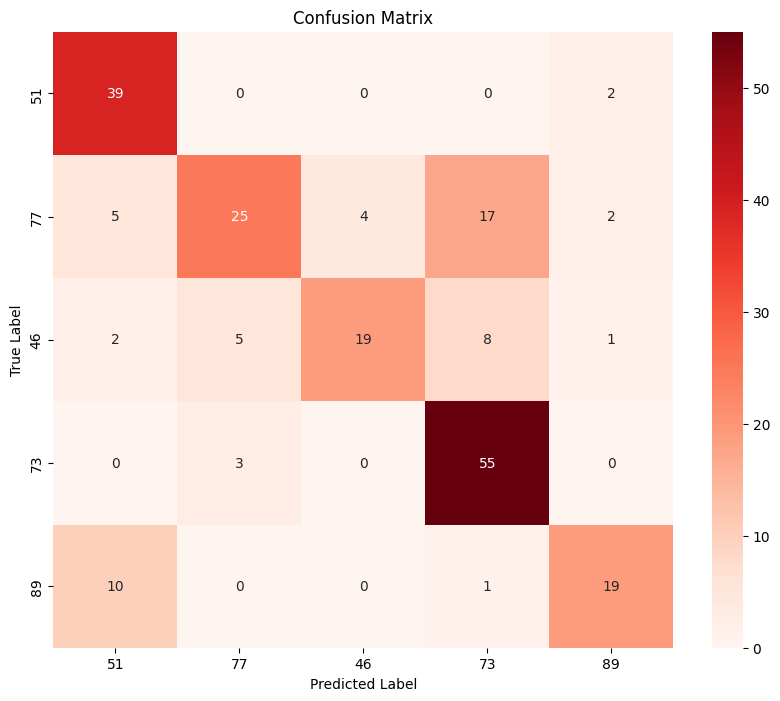

In [474]:
cm = confusion_matrix(y_test, y_pred_knn)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels = classes, yticklabels = classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve and AUC values

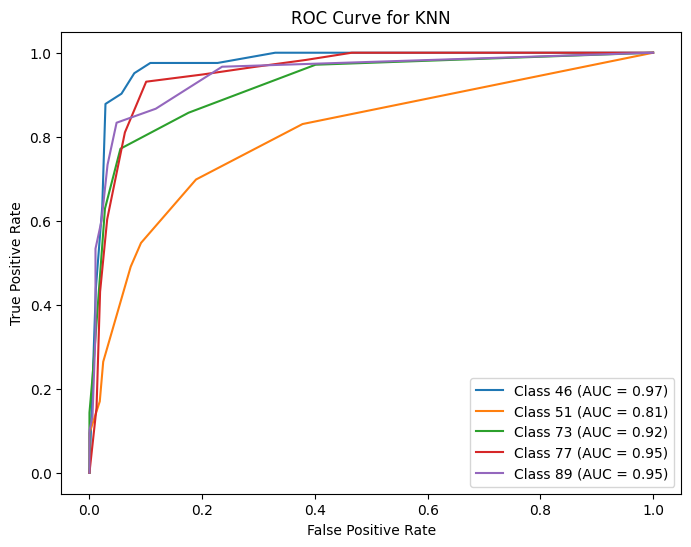

Average AUC: 0.9150
Loss : 2.3965


In [478]:
y_prob_knn = knn.predict_proba(X_test_flatten)
# Binarize the labels for multi-class ROC
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
# ploting the roc curve for each class and claculate the auc (area under curve)
plt.figure(figsize=(8, 6))
for i in range(5):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_knn[:, i])
    auc_value = roc_auc_score(y_test_bin[:, i], y_prob_knn[:, i])
    plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (AUC = {auc_value:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN')
plt.legend(loc='lower right')
plt.show()

auc_value_overall = roc_auc_score(y_test_bin, y_prob_knn, multi_class='ovr', average='weighted')
print(f"Average AUC: {auc_value_overall:.4f}")
loss = log_loss(y_test, y_prob_knn , labels=classes)
print(f"Loss : {loss:.4f}")